Linear Fit: y = 0.677x + -0.061, R² = 0.8548


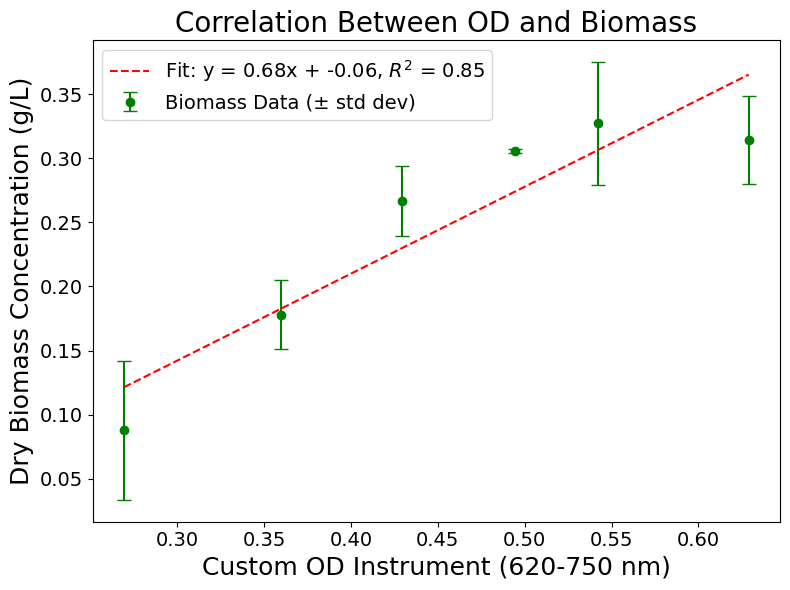

             datetime            bioreactor_time  avg_biomass   OD_calc
0 2025-07-11 14:30:00 2025-07-11 14:33:09.167697       0.0878  0.269146
1 2025-07-12 10:10:00 2025-07-12 10:37:29.535317       0.1778  0.359886
2 2025-07-13 09:30:00 2025-07-13 09:42:28.939504       0.2668  0.429351
3 2025-07-14 16:00:00 2025-07-14 15:48:59.503250       0.3056  0.494558
4 2025-07-15 10:30:00 2025-07-15 10:53:06.797003       0.3271  0.542008
5 2025-07-16 10:30:00 2025-07-16 10:58:19.186647       0.3144  0.629009


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Step 1: Hardcoded biomass data (from image)
biomass_data = [
    {'datetime': '2025-07-11 14:30', 'avg_biomass': 0.0878, 'std': 0.0542},
    {'datetime': '2025-07-12 10:10', 'avg_biomass': 0.1778, 'std': 0.0269},
    {'datetime': '2025-07-13 09:30', 'avg_biomass': 0.2668, 'std': 0.0272},
    {'datetime': '2025-07-14 16:00', 'avg_biomass': 0.3056, 'std': 0.0019},
    {'datetime': '2025-07-15 10:30', 'avg_biomass': 0.3271, 'std': 0.0477},
    {'datetime': '2025-07-16 10:30', 'avg_biomass': 0.3144, 'std': 0.0342},
]
bio_df = pd.DataFrame(biomass_data)
bio_df['datetime'] = pd.to_datetime(bio_df['datetime'])

# Step 2: Load light intensity log from bioreactor
file_path = 'color_log_2025-07-11_10-32-01.txt'
data = pd.read_csv(file_path, header=None, names=['Datetime', 'Red', 'Green', 'Blue', 'Clear'])
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')
data.dropna(subset=['Datetime'], inplace=True)

# Step 3: Calculate OD from Red intensity
I_o = 41850
data['OD_calc'] = np.log10(I_o / data['Red'])

# Step 4: Match each biomass measurement to closest OD timestamp
closest_matches = []
for _, row in bio_df.iterrows():
    target_time = row['datetime']
    closest_idx = (data['Datetime'] - target_time).abs().idxmin()
    match = data.loc[closest_idx]
    closest_matches.append({
        'datetime': target_time,
        'avg_biomass': row['avg_biomass'],
        'std': row['std'],
        'OD_calc': match['OD_calc'],
        'bioreactor_time': match['Datetime']
    })

match_df = pd.DataFrame(closest_matches)

# Step 5: Linear fit and R² calculation
x = match_df['OD_calc'].values
y = match_df['avg_biomass'].values
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b
r2 = r2_score(y, y_pred)
print(f'Linear Fit: y = {m:.3f}x + {b:.3f}, R² = {r2:.4f}')

# Step 6: Plot
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=match_df['std'], fmt='o', capsize=5, label='Biomass Data (± std dev)', color='green')
plt.plot(x, y_pred, color='red', linestyle='--', label=f'Fit: y = {m:.2f}x + {b:.2f}, $R^2$ = {r2:.2f}')

plt.xlabel('Custom OD Instrument (620-750 nm)', fontsize=18)
plt.ylabel('Dry Biomass Concentration (g/L)', fontsize=18)
plt.title('Correlation Between OD and Biomass', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Optional: Print matched data
print(match_df[['datetime', 'bioreactor_time', 'avg_biomass', 'OD_calc']])
